<a href="https://colab.research.google.com/github/Xixaus/Nastroje/blob/main/Kalibracka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metoda kalibrační přímky

Program slouží k výpočtu koncentrace vzorku pomocí metody kalibrační přímky, vyhodnocení a vytvoření příslušného grafu.

Nejdříve se připojte k hostujícímu prostředí v pravé horní části (musíte být přihlášený ke Google účtu).

Poté zadejte do první buňky hodnoty !podle návodu!, výpočet a graf vygenerujete spuštěním druhé buňky tlačítkem ▶ v levém horním rohu vedle nadpisu.

Při prvním spuštění se instaluje potřebná knihovna, tak to trvá déle, další výpočty jsou okamžité.

!!!Všechny objemy zadávejte ve stejných jednotkách, jednotlivá měření stejného roztoku oddělujte pomocí středníku (;), odezvy a objemy jednotlivých standardů pomocí lomítka (/)!!!

- X_name: Pojmenování osy x
- Y_name: Pojmenování osy y
- c_unit: zadejte jednotku koncentrace standardu (bez indexů)
- sample_unit: zadejte jednotku pro vzorky
- R_unit: zadejte jednotku měřené veličiny, která bude na y ose v grafu
- R_standard: zadejte odezvy odezvy standardů (např: 0.365; 0.360; 0.375 / 0.514; 0.51; 0.518)
- c_standards: zadejte koncetrace standardů
- R_sample: zadejte odezvy vzorku, v přídapě vyhodnocení více vzorků, oddělte odezvy / (např: 0.200; 0.204; 0.206 / 0,305; 0,325)
- Fz: faktor zředění vzorků, pro každý vzorek se zadává vlatní faktor zředění (1/1/1)

Volbou full_summary se vyppisuje úplný nebo zkrácený výpis regrese.

Pomocí volby intercept se provede regrese s úsekem. V případě že je úsek nevýznamný, bude tato skutečnost červěně napsána pod první tabulkou.

Volbou LOD bude vypočten limit detekce dle Hubauxa-Voseho pro hladinu významnosti 95%

Volbou Stats_samples se u vzorků provede výpočet směrodatné odchylky, relativní směrodatné odchylky a Dean-Dixonův test na odlehlost.

V případě že některá hodnota v kalibrační závislosti bude odlehlá, tak bude červeně zvýrazněna v tabulce na test odlehlých hodnot.

In [ ]:
#@title Vstupní hodnoty { run: "auto", vertical-output: true }
X_name = "c síranů" #@param {type:"string"}
Y_name = "NTU" #@param {type:"string"}
c_unit = 'mg/l' #@param {type:"string"}
sample_unit = 'mg/l' #@param {type:"string"}

R_standards = "7; 8; 15/ 42; 43; 43/ 93; 97; 94/ 141; 144; 138/ 176; 179; 190/ 218; 224; 219 "#@param {type:"string"}
c_standards = "0/10,04/20,08/30,12/40,16/50,20"#@param {type:"string"}

sample_names = "thiomočovina / pitná voda / minerálka" #@param {type:"string"}
R_sample = "190; 186; 189/ 92;93;93 / 71;72;70" #@param {type:"string"}
Fz =  "2 / 5 / 2.5" #@param {type:"string"}
full_summary = False #@param {type:"boolean"}
title = False #@param {type:"boolean"}
intercept = True #@param {type:"boolean"}
LOD = True #@param {type:"boolean"}
Stats_samples = True #@param {type:"boolean"}

                            OLS Regression Results                            
Dep. Variable:                 Odezva   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Úsek           6.8413      2.303      2.970      0.009       1.958      11.724
Směrnice       4.3113      0.076     56.898      0.000       4.151       4.472



,Koncetrace,Odezva,G
1,0.00,7.0,0.03
2,0.00,8.0,0.22
3,0.00,15.0,1.57
4,10.04,42.0,1.56
5,10.04,43.0,1.37
6,10.04,43.0,1.37
7,20.08,93.0,0.08
8,20.08,97.0,0.69
9,20.08,94.0,0.11
10,30.12,141.0,0.83


,thiomočovina,pitná voda,minerálka
1,190.0,92.0,71.0
2,186.0,93.0,72.0
3,189.0,93.0,70.0
Průměr,188.3,92.7,71.0
Faktor zředění,2,5,2.5
Směrodatná odchylka,2.1,0.6,1.0
Relativní směrodatná odchylka,1.1 %,0.6 %,1.4 %
-----,-----,-----,-----
Qmax,0.250,0.000,0.500
Qmin,0.750,1.000,0.500


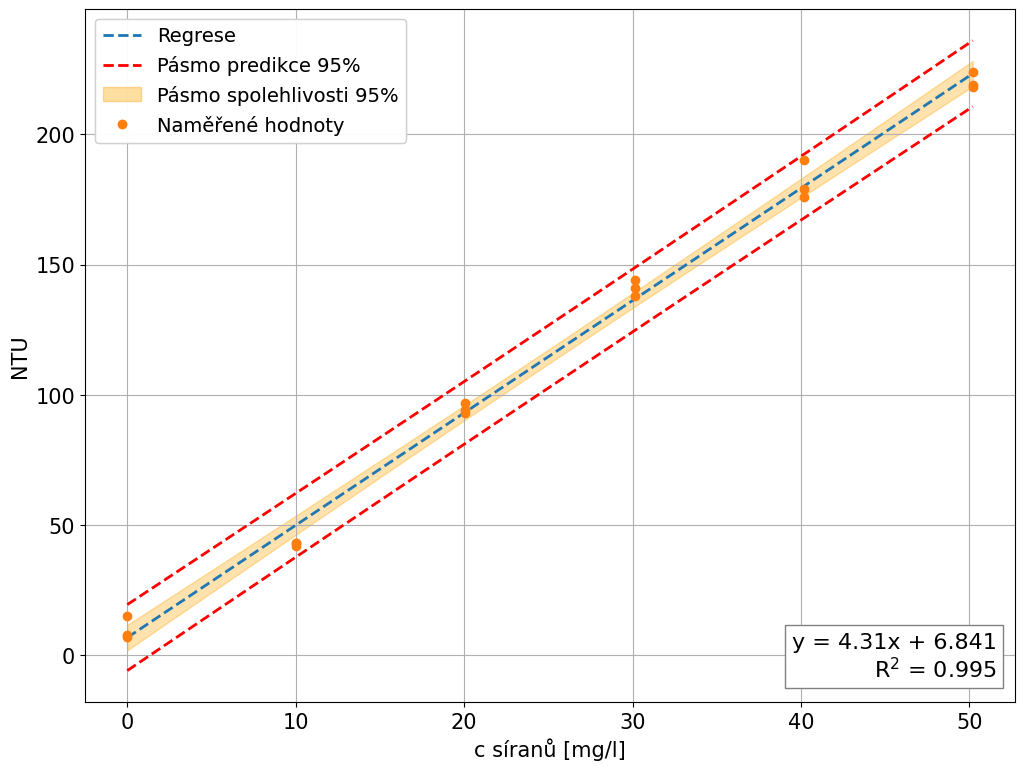

In [ ]:
#@title Graf s výsledkem

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import scipy.stats
from IPython.display import display, HTML
from scipy.optimize import fsolve

import statsmodels.api as sm

import warnings
warnings.simplefilter('ignore', sm.tools.sm_exceptions.ValueWarning)
warnings.simplefilter('ignore', sm.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)

def data_extract(R_standards, c_standards, R_sample):
    str1, str2 = c_standards.replace(",", "."), R_standards.replace(",", ".")

    list1, list2, data = str1.split('/'), str2.split('/'), []

    for i in range(len(list2)):
      for num in list2[i].split(';'):
          data.append([float(list1[i]), float(num)])

    data_1 = {}

    sample_name = sample_names.split("/")

    for i, block in enumerate(R_sample.replace(",", ".").split("/")):
        if sample_name == [""]:
            data_1[f"Vzorek {i+1}"] = block.split(";")
        else:
            data_1[sample_name[i]] = block.split(";")

    df = pd.DataFrame.from_dict(data_1, orient='index').T.astype('float')
    round_num = df.iloc[:,0].apply(count_decimals).max()

    return(pd.DataFrame(data, columns=["Koncetrace", "Odezva"]).astype('float'), df)

def count_decimals(x):
  if isinstance(x, float):
      return len(str(x).split('.')[1])
  else:
      return 0

def outlier_value(model, df, samples):
    residuals = model.resid
    Sxy = np.sqrt(model.scale)
    df["G"] = abs(residuals) / Sxy * np.sqrt(model.nobs/model.df_resid)
    t_crit = scipy.stats.t.ppf(1 - 0.1/(2*model.nobs), df=model.nobs-2)
    G_crit = ((model.nobs-1) * t_crit) / np.sqrt(model.nobs * (model.nobs-2 + t_crit**2))

    def highlight_rows(row):
        if row['G'] > G_crit:
            return ['background-color: red']*len(row)
        else:
            return ['']*len(row)

    df_0_decimals, df_1_decimals = df[df.columns[0]].apply(count_decimals).max(), df[df.columns[1]].apply(count_decimals).max()

    df.index = df.index + 1
    df = df.style.apply(highlight_rows, axis=1).format({df.columns[0]: "{:." + str(df_0_decimals) + "f}",
                                                        df.columns[1]: "{:." + str(df_1_decimals) + "f}",
                                                        "G": "{:.2f}"}
                                                        ).set_caption(f'<h2 style="font-weight: bold;">G crit 95% = {G_crit:.2f}</h2>')
    return (df)

def evaluation(model, calibration, samples, Fz, Stats_samples=False):
    X, y = calibration.iloc[:,0], calibration.iloc[:,1]
    critical_values = {1: np.nan, 2: np.nan, 3: 0.970, 4: 0.829, 5: 0.710, 6: 0.625, 7: 0.568, 8: 0.526, 9: 0.493, 10: 0.466}

    slope = model.params[-1]
    Sreg = np.sqrt(model.scale)

    result = pd.DataFrame(index=[f'Koncentrace analytu', f'Směrodatná odchylka', "Relativní směrodatná odchylka", "Interval spolehlivosti 95%"])
    samples_df = samples.copy().fillna("")
    samples_df.index = samples_df.index + 1
    round_num = samples_df.iloc[:,0].apply(count_decimals).max()

    Fz = Fz.replace(",", ".")
    Fz = Fz.split("/")

    for num, column in enumerate(samples.columns):
        sample = samples[column]
        if intercept == True:
          predict = ((sample - model.params[0])/model.params[-1]).mean() * float(Fz[num])
        else:
          predict = (sample/model.params[-1]).mean() * float(Fz[num])

        S_sample = (Sreg/abs(slope))*np.sqrt(1/model.nobs + 1/samples[column].count() + (((sample.mean() - y.mean())**2)/(slope**2 * sum(X-X.mean()**2)))) * float(Fz[num])
        Rel_std = S_sample/predict * 100
        con_int = S_sample * scipy.stats.t.ppf(q=0.975, df=model.df_resid)

        sig_num = str(float('%.2g' % S_sample))[::-1].find('.')

        result[column] = [predict.round(sig_num), S_sample.round(sig_num), Rel_std.round(1), con_int.round(sig_num)]

    result.loc["Koncentrace analytu"] = result.loc["Koncentrace analytu"].astype(str) + " " + sample_unit
    result.loc["Směrodatná odchylka"] = result.loc["Směrodatná odchylka"].astype(str) + " " + sample_unit
    result.loc["Relativní směrodatná odchylka"] = result.loc["Relativní směrodatná odchylka"].astype(str) + " %"
    result.loc["Interval spolehlivosti 95%"] = result.loc["Interval spolehlivosti 95%"].astype(str) + " " + sample_unit

    samples_df.loc["Průměr"] = samples.mean().map(lambda x: "{:.{}f}".format(x, round_num))
    samples_df.loc["Faktor zředění"] = Fz

    if Stats_samples == True:

        samples_df.loc["Směrodatná odchylka"] = samples.std().map(lambda x: "{:.{}f}".format(x, round_num))
        samples_df.loc["Relativní směrodatná odchylka"] = (samples.std() / samples.mean() * 100).round(1).astype(str) + " %"
        samples_df.loc['-----'] = '-----'

        samples_Q_test = pd.DataFrame(columns=samples_df.columns)
        samples_Q_test.loc["Qmax"] = ((samples.max() - samples.apply(lambda x: x.nlargest(2).iloc[-1])) / (samples.max() - samples.min())).map("{:.3f}".format)
        samples_Q_test.loc["Qmin"] = ((samples.apply(lambda x: x.nsmallest(2).iloc[-1]) - samples.min()) / (samples.max() - samples.min())).map("{:.3f}".format)
        samples_Q_test.loc["Qcrit"] = (samples.count().map(critical_values.get)).map("{:.3f}".format)
        samples_Q_test.loc[' ----- '] = ' ----- '
        new_df = pd.concat([samples_df, samples_Q_test, result], axis=0)

    else:
        samples_df.loc['-----'] = '-----'
        new_df = pd.concat([samples_df, result], axis=0)

    return (new_df, sig_num)

def intervals(model, df):
    x = df["Koncetrace"]
    y = df["Odezva"]
    t = scipy.stats.t.ppf(0.975, model.df_resid)
    x_line = np.linspace(np.min(x), np.max(x), 100)

    if intercept == True:
      y_line = model.predict(sm.add_constant(x_line))

      y_0 = model.predict(sm.add_constant([0]))
      ci_0 = t * np.sqrt(model.scale) * (1/model.nobs + (y_0 - x.mean())**2 / np.sum((x - x.mean())**2))**.5
    else:
      y_line = model.predict(x_line)

      y_0 = 0
      ci_0 = t * np.sqrt(model.scale) * (1/model.nobs + (y_0 - x.mean())**2 / np.sum((x - x.mean())**2))**.5

    ci = t * np.sqrt(model.scale) * (1/model.nobs + (x_line - x.mean())**2 / np.sum((x - x.mean())**2))**.5
    pi = t * np.sqrt(model.scale) * (1 + 1/model.nobs + (x_line - x.mean())**2 / np.sum((x - x.mean())**2))**.5

    intervals = pd.DataFrame([x_line, y_line,  y_line+pi, y_line-pi, y_line+ci, y_line-ci], index = ["x","y", "upp_ci", "under_ci", "upp_pi", "under_pi"]).T

    model_2 = np.poly1d(np.polyfit(intervals["x"], intervals["under_pi"], 2))

    def func(x):
        return model_2(x) - ci_0

    LOD = fsolve(func, [0, 1])[0]

    return(intervals, LOD)

calibration, samples = data_extract(R_standards, c_standards, R_sample)

if intercept == True:
  model = sm.OLS(calibration.iloc[:,1], sm.add_constant(calibration.iloc[:,0])).fit()
  x_name = ["Úsek", "Směrnice"]
else:
  model = sm.OLS(calibration.iloc[:,1], calibration.iloc[:,0]).fit()
  x_name = ["Směrnice"]

if full_summary == True:
    print(model.summary(xname=x_name))
else:
    print('\n'.join(str(model.summary().tables[0]).split('\n')[:4]))
    print(model.summary(xname=x_name).tables[1])

x, y = calibration.iloc[:,0].values, calibration.iloc[:,1].values
intervals, LOD_value = intervals(model, calibration)

criterium = sm.OLS(calibration.iloc[:,1], sm.add_constant(calibration.iloc[:,0])).fit().pvalues[0]
if criterium > 0.05:
  print()
  display(HTML(f'<p style="font-size: 15pt; font-weight: bold; color: red;">Úsek je nevýznamný! (P = {criterium:.3f})</p>'))
else:
  print()
  display(HTML(f'<p style="font-size: 15pt; font-weight: bold;">Úsek je významný (P = {criterium:.3f})</p>'))

display(HTML("<h2>Grubbsův test odlehlých hodnot</h2>"))
display(outlier_value(model, calibration, samples))
print("")

samples, sig_num = evaluation(model, calibration, samples, Fz, Stats_samples)

display(HTML("<h2>Vyhodnocení vzorků</h2>"))
display(samples)
print("")

if LOD == True:
    display(HTML(f'<p style="font-size: 15pt; font-weight: bold;">LOD: {((4/3)*(model.bse[-1] / model.params[-1])):.{3}f} {c_unit}</p>'))
    display(HTML(f'<p style="font-size: 15pt; font-weight: bold;">LOD dle Hubauxa-Vose: {LOD_value:.{3}f} {c_unit}</p>'))
    print("")

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.figure(figsize=(12, 9))
if title == True:
  plt.title("Kalibrační graf")
plt.plot(intervals["x"], intervals["y"], '--', lw=2, label="Regrese")
plt.plot(intervals["x"], intervals["under_ci"], 'r--', lw=2)
plt.plot(intervals["x"], intervals["upp_ci"], 'r--', lw=2, label="Pásmo predikce 95%")
plt.fill_between(intervals["x"], intervals["under_pi"], intervals["upp_pi"] , color='orange', alpha=0.32, label="Pásmo spolehlivosti 95%")
plt.plot(x, y, 'o', label="Naměřené hodnoty")

first_legend = plt.legend(loc='upper left')
plt.gca().add_artist(first_legend)
props = dict(boxstyle='square', facecolor='white', edgecolor='grey')

if intercept == True:
    sign = '-' if model.params[0] < 0 else '+'
    plt.text(0.98, 0.03, f'y = {model.params[1]:.3g}x {sign} {abs(model.params[0]):.3f}\nR$^2$ = {model.rsquared.round(3)}',
            transform=plt.gca().transAxes, fontsize=16, verticalalignment='bottom', horizontalalignment='right', bbox=props)

else:
    plt.text(0.98, 0.03, f'y = {model.params[0]:.3g}x \nR$^2$ = {model.rsquared.round(3)}',
            transform=plt.gca().transAxes, fontsize=16, verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.grid()
plt.xlabel(f"{X_name} [{c_unit}]")
plt.ylabel(Y_name)

plt.savefig("graph.png", bbox_inches="tight")

plt.show()
plt.close()